In [3]:
import pandas as pd
import numpy as np

In [4]:
# Let's read in one sample for now
df = pd.read_parquet('./A_[1].parquet')

In [5]:
df.head()

,time,y_diff,emf,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,input_excitation_number
0,0.000000,0.040000,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0
1,0.002176,0.040013,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0
2,0.005176,0.040074,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0
3,0.008176,0.040184,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0
4,0.011176,0.040341,0.0,0.0,0,25.356342,71.913697,429.937399,0.01,0.0,0.0,12.5,30,0


In [6]:
# Since I've done all the work ahead of time, this should _theoretically_ be just an analysis job...

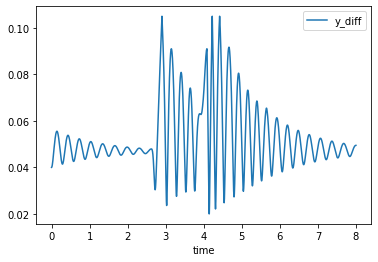

In [7]:
# Let's try plot the simulated graph of a single set of parameters
model_id = 1
df_one_curve = df.query(f'model_id == {model_id}')  # This is unique for this set of data
df_one_curve.plot(x='time', y='y_diff')

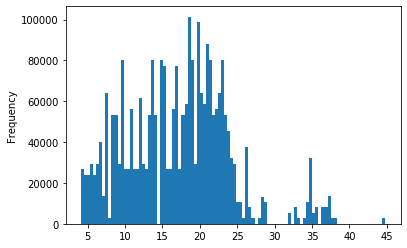

In [8]:
# Nice! Ok, let's try draw some distributions on the metrics
df['y_diff_dtw_distance'].plot(kind='hist', bins=100)

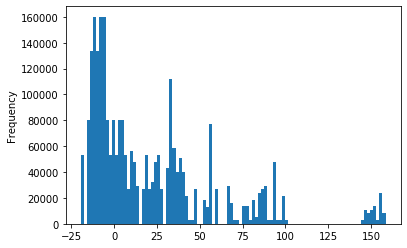

In [9]:
df['rms_perc_diff'].plot(kind='hist', bins=100)

In [10]:
# Let's draw some correlations
df.head()
param_columns = [col for col in df.columns if '.' in col]  # Parameter columns (they happen to contain a dot)
df_no_dupes = df[['y_diff_dtw_distance', 'rms_perc_diff', 'emf_dtw_distance'] + param_columns].drop_duplicates().reset_index(drop=True)

In [11]:
df_no_dupes.head()

,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,load_model.R
0,25.356342,71.913697,429.937399,0.01,0.000000,0.0,30
1,22.537314,77.274114,451.608742,0.01,1.111111,0.0,30
2,23.994554,82.032991,455.136012,0.01,2.222222,0.0,30
3,25.402237,86.632369,450.608010,0.01,3.333333,0.0,30
4,34.904624,99.800001,499.708391,0.01,4.444444,0.0,30


In [12]:
df_no_dupes.describe()

,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,load_model.R
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0
mean,17.045719,21.022607,176.344224,0.040000,5.000000,5.000000,30.0
std,6.922650,37.991480,139.134938,0.019158,3.193021,3.193021,0.0
min,4.125895,-19.214414,57.228872,0.010000,0.000000,0.000000,30.0
25%,11.926598,-8.004268,74.602765,0.023333,2.222222,2.222222,30.0
50%,17.866383,6.842957,113.390776,0.040000,5.000000,5.000000,30.0
75%,21.328984,35.876452,257.136477,0.056667,7.777778,7.777778,30.0
max,44.798652,158.475381,628.924793,0.070000,10.000000,10.000000,30.0


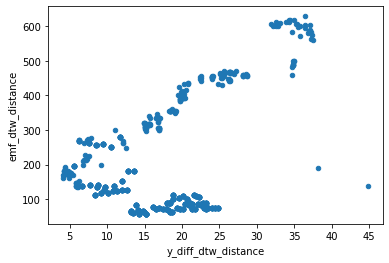

In [13]:
# Are the metrics well-correlated with each other at all?
df_no_dupes.plot(kind='scatter', x='y_diff_dtw_distance', y='emf_dtw_distance')

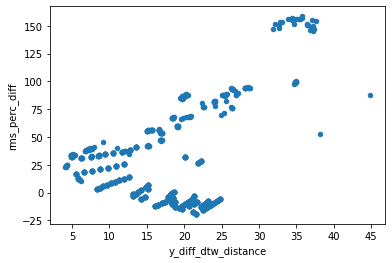

In [14]:
df_no_dupes.plot(kind='scatter', x='y_diff_dtw_distance', y='rms_perc_diff') # <-- the most important one. Really interesting results...

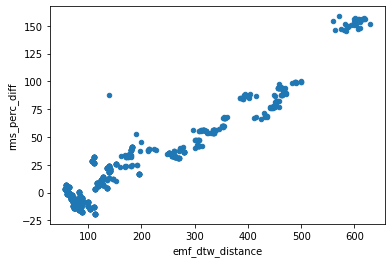

In [15]:
df_no_dupes.plot(kind='scatter', x='emf_dtw_distance', y='rms_perc_diff')

Yes! This is a good sign.

Let's do some statistical comparisons

In [16]:
from scipy import stats

In [24]:
corr, p = stats.pearsonr(df_no_dupes['emf_dtw_distance'], 
                          df_no_dupes['rms_perc_diff'])
print(corr) # <-- actually quite high for the electrical system. This is a good sign.

0.9589553081120902


In [27]:
corr, p = stats.pearsonr(df_no_dupes['y_diff_dtw_distance'],
                         df_no_dupes['rms_perc_diff'])
print(corr)

0.3280382360285876


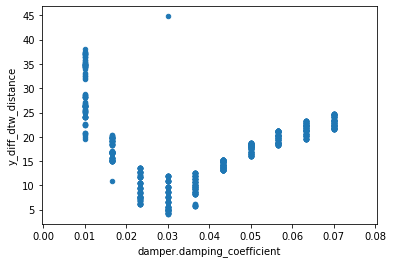

In [28]:
df_no_dupes.plot(kind='scatter', x='damper.damping_coefficient', y='y_diff_dtw_distance')

#### It seems as if the damper coefficient has a _massive_ influence on the DTW distance.

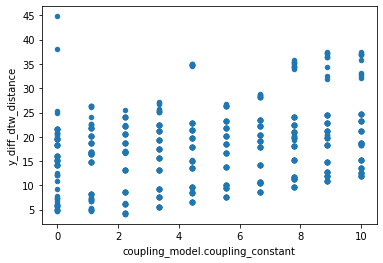

In [29]:
df_no_dupes.plot(kind='scatter', x='coupling_model.coupling_constant', y='y_diff_dtw_distance')

#### Followed by the coupling constant seemingly having some effect, but not _so_ much

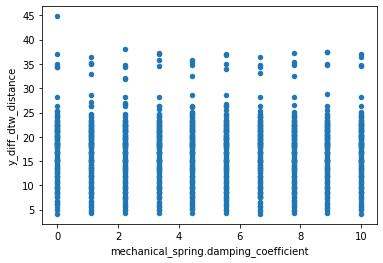

In [30]:
df_no_dupes.plot(kind='scatter', x='mechanical_spring.damping_coefficient', y='y_diff_dtw_distance')

#### The mechanical spring damping coefficient seems to have very _little_ real effect

# Analysis section (split to new Notebook later)

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client(n_workers=2)
client

Client Scheduler: tcp://127.0.0.1:34895 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 16.66 GB


In [47]:
no_curves_dfs = []
for f in ['A', 'B', 'C']:
    df = dd.read_parquet(root_path + f + '.parquet', engine='pyarrow')  # Just to get columns
    df = dd.read_parquet(root_path + f + '.parquet', engine='pyarrow', columns=[col for col in df.columns if col not in ['time', 'y_diff', 'emf']]).drop_duplicates()
    df['input_excitation'] = df['input_excitation'].astype('int')
    df['device_id'] = f.split('.')[0]
    no_curves_dfs.append(df)
    
dd.concat(no_curves_dfs).to_parquet('no_curves.parquet', engine='pyarrow', compression='snappy')

In [50]:
client.close()

---

In [1]:
from dask.distributed import Client
import dask.dataframe as dd

client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:34695 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.68 GB


In [3]:
root_path = './'
files = ['A', 'B', 'C']

In [6]:
dfs = []
for f in files:
    df = dd.read_parquet(root_path + f + '.parquet', engine='pyarrow')
    df['device_id'] = f
    df['input_excitation'] = df['input_excitation'].astype('int')
    dfs.append(df)
len(dfs)

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/pyarrow/compat.py:25: FutureWarning: pyarrow.compat has been deprecated and will be removed in a future release
  "future release", FutureWarning)


3

In [7]:
dd.concat(dfs).to_parquet(root_path + 'joined.parquet', engine='pyarrow', partition_on=['device_id', 'input_excitation'], compression='snappy')

## Start here

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
df2 = pd.read_parquet('no_curves.parquet').reset_index(drop=True)
df2.head()

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,input_excitation,device_id
0,0.0,512,12.484688,41.079664,83.644779,0.043333,2.222222,1.111111,12.5,30,0,A
1,1.0,513,13.500445,34.089880,91.988962,0.043333,3.333333,1.111111,12.5,30,0,A
2,2.0,514,14.557976,47.084719,90.270891,0.043333,4.444444,1.111111,12.5,30,0,A
3,3.0,515,15.565144,50.229976,87.382592,0.043333,5.555556,1.111111,12.5,30,0,A
4,4.0,516,17.920371,53.156539,97.112525,0.043333,6.666667,1.111111,12.5,30,0,A


In [35]:
df2_filtered = df2

In [36]:
# Some feature engineering
df2_filtered.loc[:, 'rms_perc_diff_abs'] = np.abs(df2_filtered['rms_perc_diff'])

# First normalize everything
cols_to_normalize = ['y_diff_dtw_distance', 'emf_dtw_distance', 'rms_perc_diff_abs']
for col in cols_to_normalize:
    df2_filtered.loc[:, col+'_norm'] = df2_filtered[col]/df2_filtered[col].max()
    
# Calculate extra objective functions
df2_filtered.loc[:,'balanced'] = df2_filtered['y_diff_dtw_distance_norm'] + df2_filtered['emf_dtw_distance_norm'] + df2_filtered['rms_perc_diff_abs_norm']
df2_filtered.loc[:, 'dtw_balanced'] = df2_filtered['y_diff_dtw_distance_norm'] + df2_filtered['emf_dtw_distance_norm']
df2_filtered.loc[:, 'elec_balanced'] = df2_filtered['emf_dtw_distance_norm'] + df2_filtered['rms_perc_diff_abs_norm']


# Special
df2_filtered.loc[:, 'relative_scale_weights'] = (
    + df2_filtered['y_diff_dtw_distance']/df2_filtered['y_diff_dtw_distance'].min()
    + df2_filtered['emf_dtw_distance']/df2_filtered['emf_dtw_distance'].min()
    + df2_filtered['rms_perc_diff_abs']/df2_filtered['rms_perc_diff_abs'].min()
)

df2_filtered.loc[:, 'relative_deviation'] = (
    + (df2_filtered['y_diff_dtw_distance'] - df2_filtered['y_diff_dtw_distance'].min())/df2_filtered['y_diff_dtw_distance']
    + (df2_filtered['emf_dtw_distance'] - df2_filtered['emf_dtw_distance'].min())/df2_filtered['emf_dtw_distance']
    + (df2_filtered['rms_perc_diff_abs'] - df2_filtered['rms_perc_diff_abs'].min())/df2_filtered['rms_perc_diff_abs']
)

df2_filtered.loc[:, 'normalized_sum'] = (
    + (df2_filtered['y_diff_dtw_distance'] - df2_filtered['y_diff_dtw_distance'].min())/(df2_filtered['y_diff_dtw_distance'].max() - df2_filtered['y_diff_dtw_distance'])
    + (df2_filtered['emf_dtw_distance'] - df2_filtered['emf_dtw_distance'].min())/(df2_filtered['emf_dtw_distance'].max() - df2_filtered['emf_dtw_distance'])
    + (df2_filtered['rms_perc_diff_abs'] - df2_filtered['rms_perc_diff_abs'].min())/(df2_filtered['rms_perc_diff_abs'].max() - df2_filtered['rms_perc_diff_abs'])
)

df2_filtered.loc[:, 'product'] = (
    df2_filtered['y_diff_dtw_distance']*df2_filtered['emf_dtw_distance']*df2_filtered['rms_perc_diff_abs']
)

In [37]:
df2_filtered = df2_filtered.reset_index(drop=True)
df2_filtered.head()

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,...,y_diff_dtw_distance_norm,emf_dtw_distance_norm,rms_perc_diff_abs_norm,balanced,dtw_balanced,elec_balanced,relative_scale_weights,relative_deviation,normalized_sum,product
0,0.0,512,12.484688,41.079664,83.644779,0.043333,2.222222,1.111111,12.5,30,...,0.005992,0.090897,0.000936,0.097824,0.096889,0.091832,50909.117670,2.434057,0.069177,42898.629449
1,1.0,513,13.500445,34.089880,91.988962,0.043333,3.333333,1.111111,12.5,30,...,0.006480,0.099964,0.000776,0.107220,0.106444,0.100741,42248.827285,2.482290,0.080224,42335.946208
2,2.0,514,14.557976,47.084719,90.270891,0.043333,4.444444,1.111111,12.5,30,...,0.006987,0.098097,0.001072,0.106157,0.105084,0.099170,58350.965598,2.489417,0.078811,61876.924607
3,3.0,515,15.565144,50.229976,87.382592,0.043333,5.555556,1.111111,12.5,30,...,0.007471,0.094958,0.001144,0.103573,0.102429,0.096102,62248.529989,2.489327,0.075655,68318.925539
4,4.0,516,17.920371,53.156539,97.112525,0.043333,6.666667,1.111111,12.5,30,...,0.008601,0.105532,0.001211,0.115344,0.114133,0.106743,65876.063826,2.545507,0.089496,92507.925508


In [38]:
# Remove model ids that perform really poorly

criteria = 'y_diff_dtw_distance'
cut_off = (1-0.9973)/2
cut_off*100
upper_bound = df2_filtered[criteria].quantile(0.9973+cut_off)
lower_bound = df2_filtered[criteria].quantile(1-(0.9973+cut_off))
print(lower_bound, upper_bound)

to_drop_lower = df2_filtered.query(f'{criteria} < {lower_bound}')['model_id'].values
to_drop_upper = df2_filtered.query(f'{criteria} > {upper_bound}')['model_id'].values

to_drop = np.concatenate([to_drop_lower, to_drop_upper])

df2_filtered = df2_filtered[~df2_filtered['model_id'].isin(to_drop)]

3.053013558729702 43.154019378827186


In [39]:
len(df2_filtered)

20702

In [40]:
df2_filtered.head()

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,...,y_diff_dtw_distance_norm,emf_dtw_distance_norm,rms_perc_diff_abs_norm,balanced,dtw_balanced,elec_balanced,relative_scale_weights,relative_deviation,normalized_sum,product
0,0.0,512,12.484688,41.079664,83.644779,0.043333,2.222222,1.111111,12.5,30,...,0.005992,0.090897,0.000936,0.097824,0.096889,0.091832,50909.117670,2.434057,0.069177,42898.629449
1,1.0,513,13.500445,34.089880,91.988962,0.043333,3.333333,1.111111,12.5,30,...,0.006480,0.099964,0.000776,0.107220,0.106444,0.100741,42248.827285,2.482290,0.080224,42335.946208
2,2.0,514,14.557976,47.084719,90.270891,0.043333,4.444444,1.111111,12.5,30,...,0.006987,0.098097,0.001072,0.106157,0.105084,0.099170,58350.965598,2.489417,0.078811,61876.924607
3,3.0,515,15.565144,50.229976,87.382592,0.043333,5.555556,1.111111,12.5,30,...,0.007471,0.094958,0.001144,0.103573,0.102429,0.096102,62248.529989,2.489327,0.075655,68318.925539
4,4.0,516,17.920371,53.156539,97.112525,0.043333,6.666667,1.111111,12.5,30,...,0.008601,0.105532,0.001211,0.115344,0.114133,0.106743,65876.063826,2.545507,0.089496,92507.925508


In [41]:
print(len(df2))
len(df2_filtered)

22000


20702

In [42]:
df2_filtered.query('device_id == "A"').groupby(['input_excitation']).agg({'y_diff_dtw_distance': 'mean'})

,y_diff_dtw_distance
input_excitation,
0,16.724096
1,17.877816
2,17.419066
3,15.090341
4,18.296309
5,17.868375
6,17.682649


In [43]:
def which_inputs_to_drop(df, device, number_to_drop):
    return (
        df
        .query(f'device_id == "{device}"')
        .groupby(['device_id', 'input_excitation'])
        .agg({'y_diff_dtw_distance': 'mean'})
        .sort_values(by='y_diff_dtw_distance', ascending=False)
        .reset_index()
        .iloc[:number_to_drop, :]['input_excitation']
        .values
    )

In [44]:
indexes_to_drop = []
for device, num in zip(['A', 'B', 'C'], [2, 2, 3]):
    to_drop = which_inputs_to_drop(df2_filtered, device, num)
    print(to_drop)
    x = df2_filtered[df2_filtered['input_excitation'].isin(to_drop)]
    x = x[x['device_id'] == device]
    indexes_to_drop.append(x.index)

[4 1]
[2 6]
[2 6 5]


In [45]:
indexes_to_drop

[Int64Index([1000, 1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
             ...
             4989, 4990, 4991, 4992, 4993, 4995, 4996, 4997, 4998, 4999],
            dtype='int64', length=1882),
 Int64Index([ 9000,  9001,  9002,  9003,  9004,  9005,  9006,  9007,  9008,
              9009,
             ...
             13989, 13990, 13991, 13992, 13993, 13995, 13996, 13997, 13998,
             13999],
            dtype='int64', length=1882),
 Int64Index([16000, 16001, 16002, 16003, 16004, 16005, 16006, 16007, 16008,
             16009,
             ...
             20990, 20991, 20992, 20993, 20994, 20995, 20996, 20997, 20998,
             20999],
            dtype='int64', length=2823)]

In [46]:
len(df2_filtered)

20702

In [47]:
for idx in indexes_to_drop:
    df2_filtered = df2_filtered.drop(idx)

In [48]:
len(df2_filtered)

14115

In [49]:
df_scores = df2_filtered.groupby('model_id').agg({
    'y_diff_dtw_distance': 'mean',
    'rms_perc_diff_abs': 'mean',
    'emf_dtw_distance': 'mean',
    'balanced': 'mean',
    'dtw_balanced': 'mean',
    'elec_balanced': 'mean',
    'relative_scale_weights': 'mean',
    'relative_deviation': 'mean',
    'normalized_sum': 'mean',
    'product': 'mean'
})
df_scores.head()

,y_diff_dtw_distance,rms_perc_diff_abs,emf_dtw_distance,balanced,dtw_balanced,elec_balanced,relative_scale_weights,relative_deviation,normalized_sum,product
model_id,,,,,,,,,,
0,15.266715,51.444160,229.300196,0.257679,0.256507,0.250352,63757.532366,2.605332,0.324121,472081.959608
1,16.540170,65.977495,266.820083,0.299394,0.297891,0.291455,81767.373892,2.630106,0.430041,770847.360913
2,18.683305,81.246030,302.265933,0.339289,0.337439,0.330322,100688.473761,2.712242,0.500790,797769.698301
3,19.236310,83.566785,314.166147,0.352539,0.350636,0.343307,103564.708457,2.740146,0.529216,657356.373631
4,22.030305,95.430113,345.186100,0.387860,0.385686,0.377286,118266.567878,2.776060,0.652822,899740.675207


In [50]:
df2_filtered.groupby('model_id').mean().sort_values(by='y_diff_dtw_distance')

,grid_cell_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,input_excitation,...,y_diff_dtw_distance_norm,emf_dtw_distance_norm,rms_perc_diff_abs_norm,balanced,dtw_balanced,elec_balanced,relative_scale_weights,relative_deviation,normalized_sum,product
model_id,,,,,,,,,,,,,,,,,,,,,
301,5.0,6.834680,21.323785,103.540688,0.03,1.111111,0.000000,17.933333,30.0,2.933333,...,0.003280,0.112517,0.000542,0.116340,0.115798,0.113060,29505.072786,2.274989,0.093209,1.946936e+04
311,7.0,6.929788,21.498280,103.489932,0.03,1.111111,1.111111,17.933333,30.0,2.933333,...,0.003326,0.112462,0.000541,0.116329,0.115788,0.113003,29442.782613,2.274423,0.093248,2.041301e+04
361,1.0,6.936725,21.718102,101.320068,0.03,1.111111,6.666667,17.933333,30.0,2.933333,...,0.003329,0.110104,0.000547,0.113981,0.113434,0.110651,29769.883607,2.266039,0.090508,2.002055e+04
331,3.0,6.946615,21.679399,101.372574,0.03,1.111111,3.333333,17.933333,30.0,2.933333,...,0.003334,0.110161,0.000541,0.114036,0.113495,0.110702,29412.290208,2.262837,0.090544,2.010582e+04
381,5.0,6.955981,22.224005,103.382249,0.03,1.111111,8.888889,17.933333,30.0,2.933333,...,0.003339,0.112345,0.000561,0.116245,0.115684,0.112906,30537.670282,2.283444,0.092947,2.037617e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,3.0,27.835385,142.112370,453.233979,0.01,10.000000,10.000000,17.933333,30.0,2.933333,...,0.013360,0.492528,0.003237,0.509125,0.505888,0.495765,176115.926161,2.836274,1.135100,1.866112e+06
57,1.0,27.973584,144.800922,445.072709,0.01,7.777778,5.555556,17.933333,30.0,2.933333,...,0.013426,0.483659,0.003298,0.500383,0.497085,0.486957,179447.071218,2.828968,1.141847,2.066562e+06
89,1.0,28.340162,140.881769,451.965359,0.01,10.000000,8.888889,17.933333,30.0,2.933333,...,0.013602,0.491149,0.003209,0.507960,0.504751,0.494358,174591.261053,2.838093,1.144465,1.851137e+06


In [51]:
# Let's get the best performing model ids for each objective_function
best_model_ids = {}
for obj_func in df_scores.columns:
    best_model_id = df_scores.sort_values(by=obj_func).index[0]
    best_model_ids[obj_func] = best_model_id
    
best_model_ids

{'y_diff_dtw_distance': 301,
 'rms_perc_diff_abs': 870,
 'emf_dtw_distance': 661,
 'balanced': 661,
 'dtw_balanced': 661,
 'elec_balanced': 661,
 'relative_scale_weights': 870,
 'relative_deviation': 681,
 'normalized_sum': 661,
 'product': 681}

In [52]:
df2_filtered.head()

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_resistance,load_model.R,...,y_diff_dtw_distance_norm,emf_dtw_distance_norm,rms_perc_diff_abs_norm,balanced,dtw_balanced,elec_balanced,relative_scale_weights,relative_deviation,normalized_sum,product
0,0.0,512,12.484688,41.079664,83.644779,0.043333,2.222222,1.111111,12.5,30,...,0.005992,0.090897,0.000936,0.097824,0.096889,0.091832,50909.117670,2.434057,0.069177,42898.629449
1,1.0,513,13.500445,34.089880,91.988962,0.043333,3.333333,1.111111,12.5,30,...,0.006480,0.099964,0.000776,0.107220,0.106444,0.100741,42248.827285,2.482290,0.080224,42335.946208
2,2.0,514,14.557976,47.084719,90.270891,0.043333,4.444444,1.111111,12.5,30,...,0.006987,0.098097,0.001072,0.106157,0.105084,0.099170,58350.965598,2.489417,0.078811,61876.924607
3,3.0,515,15.565144,50.229976,87.382592,0.043333,5.555556,1.111111,12.5,30,...,0.007471,0.094958,0.001144,0.103573,0.102429,0.096102,62248.529989,2.489327,0.075655,68318.925539
4,4.0,516,17.920371,53.156539,97.112525,0.043333,6.666667,1.111111,12.5,30,...,0.008601,0.105532,0.001211,0.115344,0.114133,0.106743,65876.063826,2.545507,0.089496,92507.925508


In [54]:
best_param_sets = {
    r'$\texttt{dtw\_mech}$': best_model_ids['y_diff_dtw_distance'],
    r'$\texttt{dtw\_elec}$': best_model_ids['emf_dtw_distance'],
    r'$\texttt{rms\_perc\_abs}$': best_model_ids['rms_perc_diff_abs'],
    r'$\texttt{balanced}$': best_model_ids['balanced'],
    r'$\texttt{dtw\_both}$': best_model_ids['dtw_balanced'],
    r'$\texttt{rms\_dtw\_elec}$': best_model_ids['elec_balanced'],
    r'$\texttt{scale\_weights}$': best_model_ids['relative_scale_weights'],
    r'$\texttt{relative\_dev}$': best_model_ids['relative_deviation'],
    r'$\texttt{norm\_sum}$': best_model_ids['normalized_sum'],
    r'$\texttt{product}$': best_model_ids['product'],
}
best_param_sets

{'$\\texttt{dtw\\_mech}$': 301,
 '$\\texttt{dtw\\_elec}$': 661,
 '$\\texttt{rms\\_perc\\_abs}$': 870,
 '$\\texttt{balanced}$': 661,
 '$\\texttt{dtw\\_both}$': 661,
 '$\\texttt{rms\\_dtw\\_elec}$': 661,
 '$\\texttt{scale\\_weights}$': 870,
 '$\\texttt{relative\\_dev}$': 681,
 '$\\texttt{norm\\_sum}$': 661,
 '$\\texttt{product}$': 681}

In [55]:
model_id_to_metric_name = {v: k for k, v in best_param_sets.items()}
model_id_to_metric_name

{301: '$\\texttt{dtw\\_mech}$',
 661: '$\\texttt{norm\\_sum}$',
 870: '$\\texttt{scale\\_weights}$',
 681: '$\\texttt{product}$'}

In [56]:
df_filtered_scores = df2_filtered[df2_filtered.model_id.isin(best_param_sets.values())]
df_filtered_scores['metric_name'] = df_filtered_scores['model_id'].apply(lambda x: model_id_to_metric_name[x])
df_filtered_scores.head()

df_filtered_scores.columns = [col.replace('_', '.') for col in df_filtered_scores.columns]  # Required to stop Latex from exploding
df_filtered_scores.head()

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,grid.cell.id,model.id,y.diff.dtw.distance,rms.perc.diff,emf.dtw.distance,damper.damping.coefficient,coupling.model.coupling.constant,mechanical.spring.damping.coefficient,coil.resistance,load.model.R,...,emf.dtw.distance.norm,rms.perc.diff.abs.norm,balanced,dtw.balanced,elec.balanced,relative.scale.weights,relative.deviation,normalized.sum,product,metric.name
94,6.0,870,13.760081,15.018300,66.427083,0.063333,0.000000,7.777778,12.5,30,...,0.072186,0.000342,0.079132,0.078790,0.072528,18616.696999,2.357787,0.047756,13727.357287,$\texttt{scale\_weights}$
253,5.0,661,12.028803,31.065747,67.419869,0.050000,1.111111,6.666667,12.5,30,...,0.073265,0.000708,0.079746,0.079038,0.073973,38500.263358,2.338452,0.048495,25193.710080,$\texttt{norm\_sum}$
285,5.0,301,10.378102,55.568862,84.981692,0.030000,1.111111,0.000000,12.5,30,...,0.092349,0.001266,0.098596,0.097330,0.093615,68861.734476,2.399177,0.070188,49008.883728,$\texttt{dtw\_mech}$
465,1.0,681,12.028803,31.065747,67.419869,0.050000,1.111111,8.888889,12.5,30,...,0.073265,0.000708,0.079746,0.079038,0.073973,38500.263358,2.338452,0.048495,25193.710080,$\texttt{product}$
2565,5.0,301,6.959003,29.146381,120.127833,0.030000,1.111111,0.000000,12.5,30,...,0.130543,0.000664,0.134546,0.133883,0.131206,36121.690949,2.386147,0.114721,24365.499444,$\texttt{dtw\_mech}$


In [57]:
def make_ridge_plot(df, row, distribution_metric, x_axis_label, output_path):
    sns.set(style="white",
            rc={"axes.facecolor": (0, 0, 0, 0),
                'text.usetex': True,
                'text.latex.preamble': r'\usepackage{amsmath}',
                'font.family': 'serif'},
            font_scale=1.7)
    
    g = sns.FacetGrid(df, row=row, hue=row, aspect=15, height=0.8)
    g.map(sns.kdeplot, distribution_metric, shade=True, clip_on=False, alpha=1, bw=1)
    g.map(sns.kdeplot, distribution_metric, clip_on=False, color='w', lw=2, alpha=1, bw=1)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    def label(x, color, label):
        ax = plt.gca()
        #ax.text(0, .15, model_id_to_metric_name[int(label)], ha='left', va='center', transform=ax.transAxes, color=color)
        ax.text(0, .15, label, ha='left', va='center', transform=ax.transAxes, color=color)
        
    g.map(label, row)
    
    g.set_titles("")
    g.set_axis_labels(distribution_metric)
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.subplots_adjust(hspace=-0.2)
    g.set_axis_labels(x_axis_label) 
    g.savefig(output_path)

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
/home/michael/miniconda3/envs/ds/lib/python3.7/site-

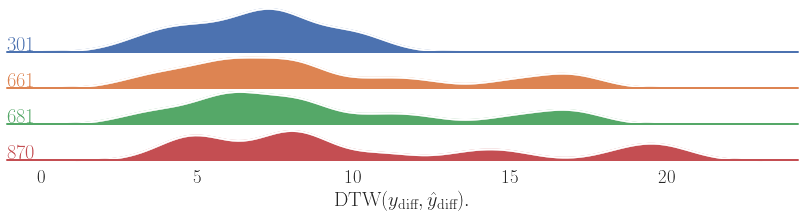

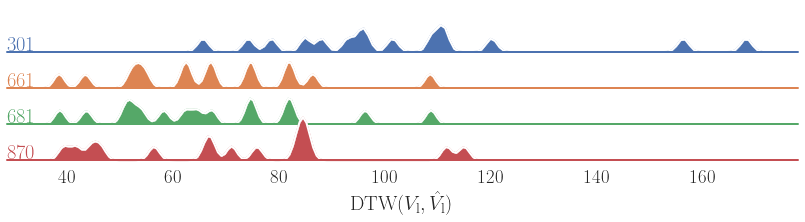

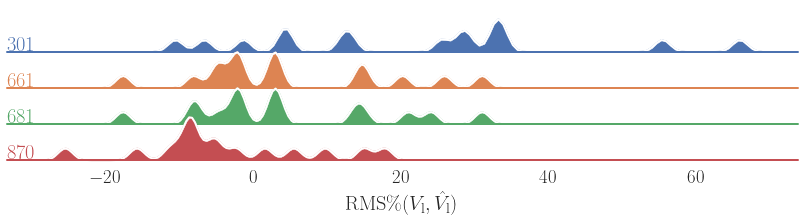

In [58]:
path = '/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/'
make_ridge_plot(df_filtered_scores, 'model.id', 'y.diff.dtw.distance', r'$\text{DTW}(y_{\text{diff}},  \hat{y}_{\text{diff}}).$', '/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/param_select_dtw_mech.pdf')
make_ridge_plot(df_filtered_scores, 'model.id', 'emf.dtw.distance', r'$\text{DTW}(V_{\text{l}}, \hat{V}_{\text{l}})$', '/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/param_select_dtw_elec.pdf')
make_ridge_plot(df_filtered_scores, 'model.id', 'rms.perc.diff', r'$\text{RMS\%}(V_{\text{l}}, \hat{V}_{\text{l}})$', '/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/param_select_rms.pdf')

In [26]:
best_param_sets

{'$\\texttt{dtw\\_mech}$': 301,
 '$\\texttt{dtw\\_elec}$': 661,
 '$\\texttt{rms\\_perc\\_abs}$': 870,
 '$\\texttt{balanced}$': 661,
 '$\\texttt{dtw\\_both}$': 661,
 '$\\texttt{rms\\_dtw\\_elec}$': 661}

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
Client()

Client Scheduler: tcp://127.0.0.1:39719 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.66 GB


In [2]:
# Ok, let's try load the groundtruth
# Let's get some groundtruth in here
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any


class GroundTruthFactory:
    def __init__(self, samples_list, lvp_kwargs, adc_kwargs):
        self.samples_list = samples_list
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs
        
        @dataclass
        class MechanicalGroundtruth:
            y_diff: Any
            time: Any
        
        @dataclass
        class ElectricalGroundtruth:
            emf: Any
            time: Any
        
        @dataclass
        class Groundtruth:
            mech: MechanicalGroundtruth
            elec: ElectricalGroundtruth

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)
        self.MechGroundtruth = MechanicalGroundtruth
        self.ElecGroundtruth = ElectricalGroundtruth
        self.Groundtruth = Groundtruth

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 9, 3)

        return self.MechGroundtruth(y_target,
                                    y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return self.ElecGroundtruth(emf_target,
                                    emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            mech_groundtruth = self._make_mechanical_groundtruth(sample)
            elec_groundtruth = self._make_electrical_groundtruth(sample)

            groundtruths.append(
                self.Groundtruth(mech_groundtruth, elec_groundtruth)
            )

        return groundtruths

# Prepare data
base_groundtruth_path = './data/2019-05-23_D/'
samples = {}
samples['A'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='A/*acc*.csv',
                               adc_pattern='A/*adc*.csv',
                               video_label_pattern='A/*labels*.csv')
samples['B'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='B/*acc*.csv',
                               adc_pattern='B/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')
samples['C'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='C/*acc*.csv',
                               adc_pattern='C/*adc*.csv',
                               video_label_pattern='C/*labels*.csv')



In [3]:
# Groundtruth

groundtruth = {}
for device in ['A', 'B', 'C']:
    groundtruth_factory = GroundTruthFactory(samples_list=samples[device][:],
                                             lvp_kwargs=dict(mm=10,
                                                             seconds_per_frame=1/60,
                                                             pixel_scale=0.154508),
                                             adc_kwargs=dict(voltage_division_ratio=1 / 0.342)  # noqa
    )
    groundtruth[device] = groundtruth_factory.make()

In [4]:
# Let's look at some examples from each

In [5]:
import dask.dataframe as dd 

def get_curve(df_curves_path, model_id, input_excitation_number, device_id):
    #df_curves = vaex.open(df_curves_path)[['model_id', 'input_excitation_number', 'device_id', 'time', 'emf', 'y_diff']]
    df_curves = dd.read_parquet(df_curves_path,
                                columns=['model_id', 'input_excitation', 'device_id', 'time', 'emf', 'y_diff'],
                                filters=[('device_id', '==', device_id), ('input_excitation', '==', input_excitation_number)])
    df_temp = df_curves[df_curves['model_id'] == model_id]
    df_temp = df_temp[df_temp['input_excitation'] == input_excitation_number]
    df_temp = df_temp[df_temp['device_id'] == device_id].compute()
    return df_temp.sort_values(by='time')

In [6]:
def compare_mech(df_curves_path, groundtruth, model_id, input_excitation_number, device_id):
    x = get_curve(df_curves_path, model_id, input_excitation_number, device_id)
    
    
    mech_eval = evaluate.MechanicalSystemEvaluator(
        y_target = groundtruth[device_id][input_excitation_number].mech.y_diff,  # Referenced to zero
        time_target = groundtruth[device_id][input_excitation_number].mech.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance}
    )

    mech_eval.fit(
        y_predict = x['y_diff'].values,
        time_predict = x['time'].values
    )
    print(mech_eval.score())
    mech_eval.poof(figsize=(16,8))
    del x

In [86]:
def compare_elec(df_curves_path, groundtruth, model_id, input_excitation_number, device_id):
    x = get_curve(df_curves_path, model_id, input_excitation_number, device_id)
    
    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=groundtruth[device_id][input_excitation_number].elec.emf,  # Referenced to zero
        time_target=groundtruth[device_id][input_excitation_number].elec.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance,
                  'rms_perc_diff': metrics.root_mean_square_percentage_diff},
        clip_threshold=1e-4
    )
    
    elec_eval.fit(
        emf_predict=x['emf'].values,
        time_predict=x['time'].values
    )
    print(elec_eval.score())
    print(max(elec_eval.emf_target))
    elec_eval.poof(figsize=(16, 8))
    del x

In [87]:
df2_filtered.query('device_id == "B" and input_excitation == 0 and model_id==661')

NameError: name 'df2_filtered' is not defined

In [88]:
from scipy import signal

In [89]:
import numpy as np

x = np.array([1,2,3,4,3,2,1])
y = np.array([1,2,3,2,1])

signal.correlate(x, y, mode='full')

array([ 1,  4, 10, 18, 25, 28, 25, 18, 10,  4,  1])

{'dtw_distance': 12.042898996206892}


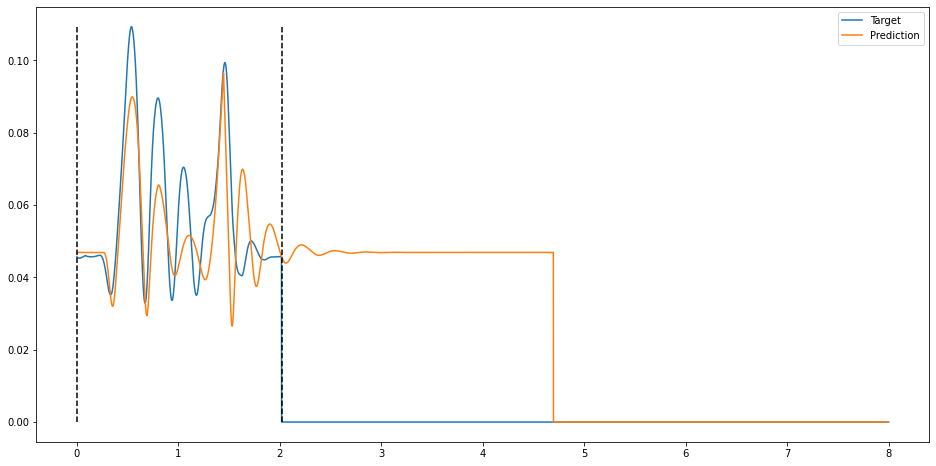

{'dtw_distance': 75.41608305706, 'rms_perc_diff': 28.041504489471926}
0.7945411860113379


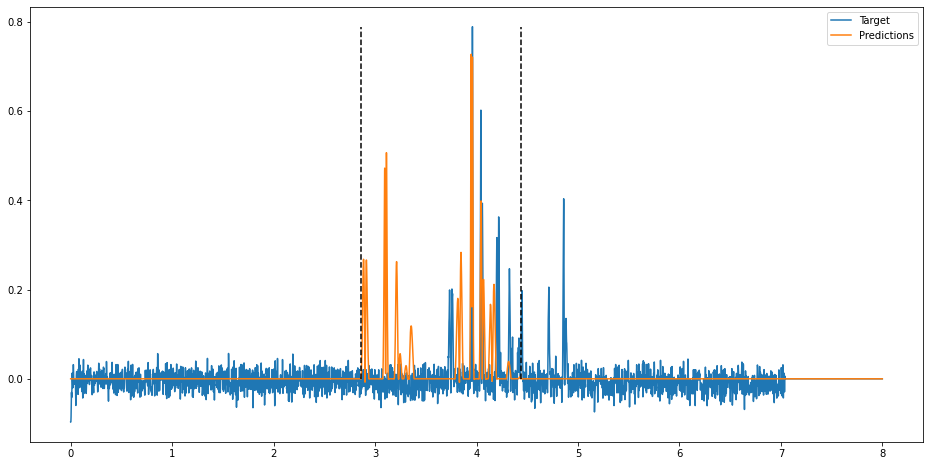

In [109]:
input_ = 0
device = 'A'
chosen_model_id = 661

compare_mech('joined.parquet', groundtruth, chosen_model_id, input_, device)
compare_elec('joined.parquet', groundtruth, chosen_model_id, input_, device)

In [12]:
df_sample = get_curve('joined.parquet', 661, 0, 'A')

In [94]:
g = groundtruth['A'][0]
g.elec

GroundTruthFactory.__init__.<locals>.ElectricalGroundtruth(emf=array([-0.09693569, -0.09692511, -0.09685137, ...,  0.00453655,
        0.0069157 ,  0.00244608]), time=array([0.000000e+00, 6.250000e-04, 1.250000e-03, ..., 7.038125e+00,
       7.038750e+00, 7.039375e+00]))

In [95]:
pred_time = df_sample['time'].values
pred_emf = df_sample['emf'].values

truth_time = g.elec.time
truth_emf = g.elec.emf

In [96]:
import matplotlib.pyplot as plt

def plot_comparison(pred_time, pred_emf, truth_time, truth_emf):
    plt.figure(figsize=(16, 8))
    plt.plot(pred_time, pred_emf, 'r')
    plt.plot(truth_time, truth_emf, 'k', alpha=0.5)

In [97]:
# Start experiment
from scipy import signal

# sampling periods
sampling_period_pred_time = np.mean(np.gradient(pred_time))
sampling_period_truth_time = np.mean(np.gradient(truth_time))

# Figure out up/down sampling ratio
ratio = sampling_period_pred_time/sampling_period_truth_time
ratio = np.round(ratio, 3)
up = ratio*1e3
down = 1e3

# We need to do a resampling period first
pred_emf_scaled = signal.resample_poly(pred_emf, up, down)

In [98]:
print(ratio)

4.798


In [99]:
pred_time_scaled = np.arange(0., max(pred_time), sampling_period_pred_time/ratio)
pred_time_scaled

array([0.00000000e+00, 6.25005252e-04, 1.25001050e-03, ...,
       7.99631719e+00, 7.99694220e+00, 7.99756720e+00])

12797
12802


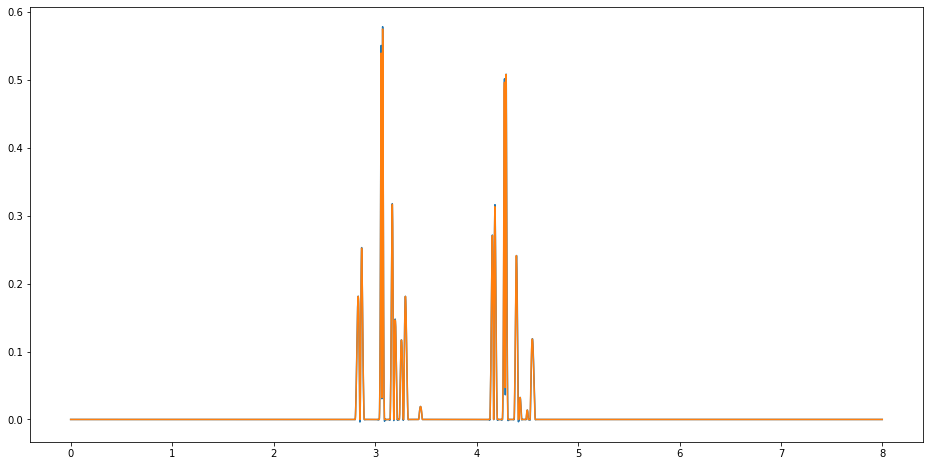

In [100]:
print(len(pred_time_scaled))
print(len(pred_emf_scaled))

# Just make sure any odd samples get clipped
pred_emf_scaled = pred_emf_scaled[:len(pred_time_scaled)]
pred_time_scaled = pred_time_scaled[:len(pred_emf_scaled)]

# Plot
plt.figure(figsize=(16, 8))
plt.plot(pred_time_scaled, pred_emf_scaled)
plt.plot(pred_time, pred_emf)

In [101]:
# Now that we've resampled, we can do correlation
corr_12 = signal.correlate(pred_emf_scaled, truth_emf)
corr_21 = signal.correlate(truth_emf, pred_emf_scaled)

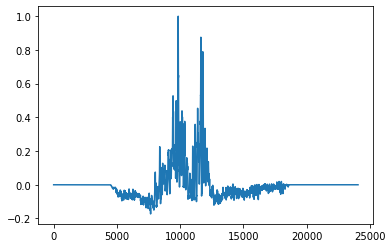

In [102]:
plt.plot(corr_12/max(corr_12))

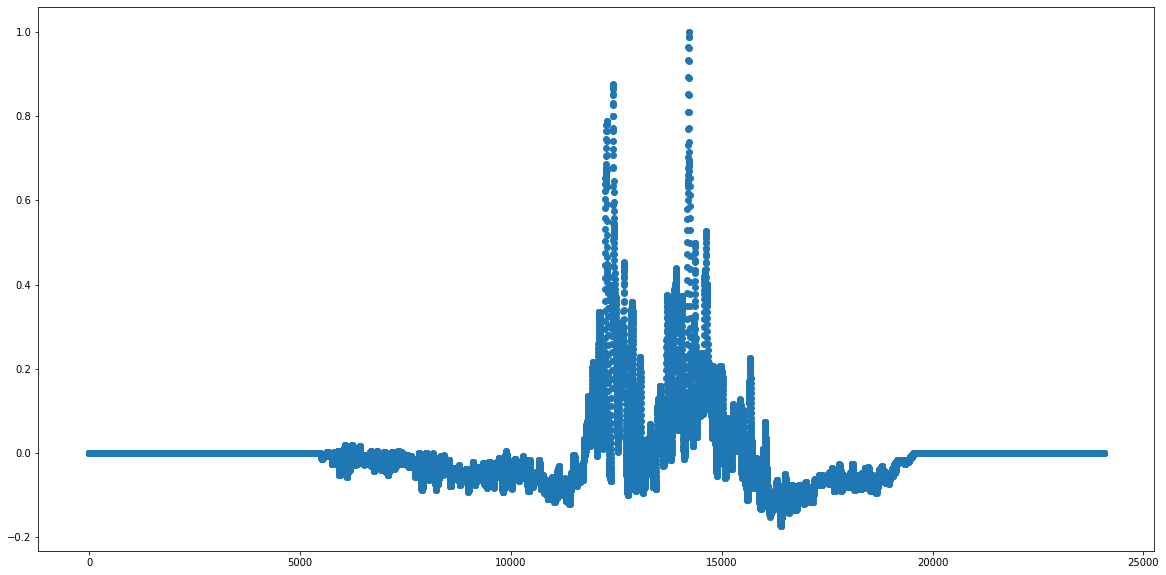

In [118]:
plt.figure(figsize=(20, 10))
plt.plot(corr_21/max(corr_21), 'o')

In [117]:
import heapq

first_pos = np.argmax(corr_12)
second_pos = np.argmax(corr_21)

corr_12[first_pos] = 0
np.argmax(corr_12)


9844

In [111]:
difference = first_pos - second_pos
difference

-4369

In [106]:
if difference < 0:
    padded_pred = np.pad(pred_emf_scaled, (abs(difference), 0), 'constant')

In [119]:
from unified_model.utils.utils import find_signal_limits

In [137]:
# Another technique

start_truth, end_truth = find_signal_limits(truth_emf, 0.075)
start_pred, end_pred = find_signal_limits(pred_emf_scaled, 0.05)

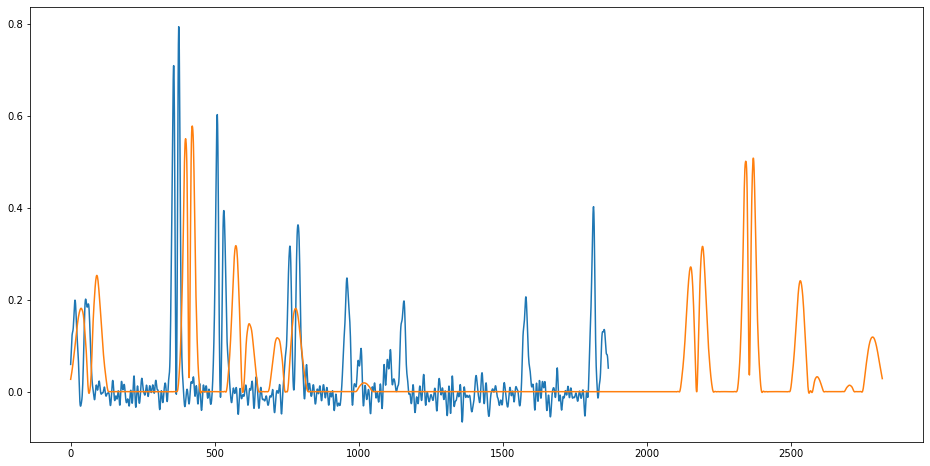

In [138]:
plt.figure(figsize=(16, 8))
plt.plot(truth_emf[start_truth:end_truth])
plt.plot(pred_emf_scaled[start_pred:end_pred])